In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Function, lambdify, simplify, im
from sympy.solvers import solve

!["img1"](./img1.png)

We need to graph absolute value of $V_2/V_1$ over $\omega / \omega_r$ where $\omega_r$ is a resonance frequency. $L=100mH$ and $C=10\mu F$.  We calculate impedance of the whole circuit first:

$$Z = R + j\omega L + \left(R + j \omega L\right)\parallel\left(\frac{1}{j\omega C}\right) \\
Z = R + j\omega L + \frac{R + j\omega L}{1+j\omega RC - \omega^2 LC}
$$

In [2]:
# create symbols
r, l, c, z = symbols('R L C Z')
w = symbols('\omega', positive="True")

# write expression of impedance
z = r + 1j*w*l + (r + 1j*w*l)/(1 + 1j*w*r*c - w**2*l*c)

# create 'values' dictionary for substitution
values = {r: 141.4, l: 100e-3, c:10e-6}

Now that we have an expression for impedance, we can calculate $I_{ph}=V_{ph}/Z$:

In [3]:
# create function
i_ph = Function('I')(w)
# assign value to it
i_ph = 10/z
# substitute known values
i_ph = i_ph.subs(values)

After getting $I_{ph}$ as a function of $\omega$, we are able to plot its absolute value:

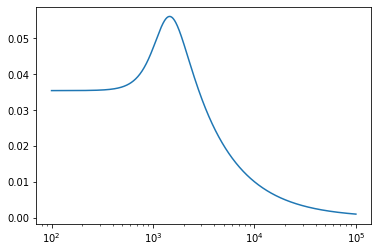

In [4]:
x = np.logspace(2, 5, 1000)
y = lambdify(w, i_ph, 'numpy')

plt.semilogx(x, abs(y(x)));

As we can see, absolute value of current has only one peak, but more on that later. Now we can compute $V_1$ which is equal to $I_{ph}R$:

In [5]:
v1 = i_ph*r

We also compute $V_2$ with the help of current division rule:

In [6]:
# compute current through resistance on the right
i_right = i_ph * (1/(1j*w*c)) / (1/(1j*w*c) + r + 1j*w*l)

# calculate v2
v2 = i_right * r

Now we can plot $\left|H\left(\omega \right) \right| = \left|\frac{V_2}{V_1}\right|$ as a function of $\omega$:

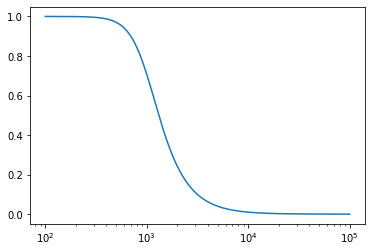

In [7]:
H = Function('H')(w)
H = v2/v1
H = H.subs(values)

x = np.logspace(2, 5, 1000)
y = lambdify(w, abs(H), 'numpy')
plt.semilogx(x, y(x));

So far so good, but when we arrive at computing $\omega_r$, it gets very confusing. During the lecture we said that $\omega_r=\sqrt{\cfrac{2}{LC}}$, but is that really true? 

We got that answer by acquiring thevenin equivalent circuit on the terminals of capacitor and equating imaginary part of total impedance to zero, like this:

!["img2"](./img2.png)

$$Z = \frac{R}{2}+j\left(\frac{\omega L}{2} - \frac{1}{\omega C}\right) \implies \frac{\omega L}{2}- \frac{1}{\omega C} = 0 \implies 
\frac{\omega^2LC}{2}=0 \implies \omega_r = \sqrt{\cfrac{2}{LC}}
$$

But frequency we got was for thevenin equivalent circuit. Thevenin equivalent circuit preserves current and voltage <b>only through load</b> (in this case capacitor), but is that neccessary that $\omega_r$ of thevenin equivalent circuit is equal to $\omega_r$ of original circuit?

If that is so, then it should also work on the circuit given below:

!["img2"](./img3.png)

This circuit resonates at $0$ and $\infty$ frequencies, it is a band stop filter. but if we get thevenin equivalent circuit with an inductor as load and calculate its resonant frequency, we get this:

$$
Z_{th} = 1 \parallel \frac{-j}{\omega} = \frac{-j}{\omega - j} \\
$$

$$Z = Z_{th} + j\omega = \frac{-j}{\omega - j} + j\omega = \frac{-j(j+\omega) + j\omega(1+\omega^2)}{1+\omega^2} = \frac{1-{j\omega} +j\omega+j\omega^3}{1+\omega^2}$$

$$\operatorname{Im}Z = \frac{\omega^3}{1+\omega^2} = 0\implies \omega = 0$$

Which means that resonant frequencies do not match.

If finding thevenin equivalent circuit is not applicable in this example, why did we use it for solving our original problem? I think we made a mistake by assuming that thevenin equivalent circuit preserves all circuit charasteristics, including resonant frequency. In fact, if we substitute $\omega_r = \sqrt{\cfrac{2}{LC}}=1000\sqrt{2}$ back into expression for impedance, we'll get complex number:

In [8]:
wr = 1000*np.sqrt(2)

# substitute R, L, C in Z
z = z.subs(values)
# substitute omega in Z and print it
simplify(z.subs(w, wr))

169.686834099118 + 56.5651249292733*I

But from the definition of resonant frequency, impedance must be real and not complex like we got by substitution. This means that $\sqrt{\cfrac{2}{LC}}$ cannot be a resonant frequency. But if that isn't the correct answer, then what is?

If we want to find $\omega_r$, we must solve $\operatorname{Im}Z = 0$. I don't know an easy way of doing that. Just simplifying an expression for impedance until I isolate its imaginary part seems like the only way, but it's tedious (and maybe sometimes impossible) to solve by hand. Let python do this work for us:

In [9]:
solutions = solve(im(z), w)

print(solutions)

[24.5764114548890, 1000.00000000000]


Turns out that $\omega_r$ has two values. I'm still a bit confused why those values didn't show up in graph. Is it because that by solving simpler circuits I wrongly assumed absolute value of current always has peak only at resonant frequencies? Also, I expected current to have two peaks because of two resonant frequencies, but nothing really happens at these values:

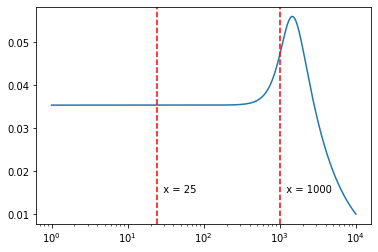

In [10]:
# plot current again
x = np.logspace(0, 4, 1000)
y = lambdify(w, i_ph, 'numpy')

plt.semilogx(x, abs(y(x)))

# plot vertical lines where solutions are
for sol in solutions:
    plt.axvline(sol, color='r', ls='--')
    plt.text(sol, 0.015, '  x = ' + str(round(sol)), rotation=0)

But when we plot the angle of current, it really gets $0$ at resonant frequencies (it means that impedance is real there), which confirms that $\omega = 24.58$ and $\omega = 1000$ are resonant frequencies insead of $\omega = 1000\sqrt{2}$:

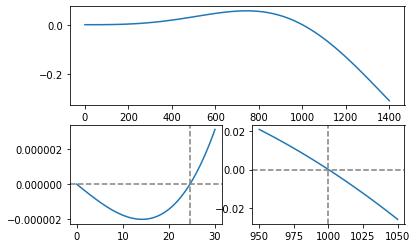

In [11]:
y = lambdify(w, i_ph, 'numpy')

# plot angle of current
ax1 = plt.subplot(2, 2, (1, 2))
x = np.linspace(0, 1400, 100)
ax1.plot(x, np.angle(y(x)))

# zoom in for first solution
ax2 = plt.subplot(2, 2, 3)
x = np.linspace(0, 30, 100)
ax2.plot(x, np.angle(y(x)))
ax2.axvline(24.58, color='gray', ls='--')
ax2.axhline(0, color='gray', ls='--')

# zoom in for second solution
ax3 = plt.subplot(2, 2, 4)
x = np.linspace(950, 1050, 100)
ax3.plot(x, np.angle(y(x)))
ax3.axvline(1000, color='gray', ls='--')
ax3.axhline(0, color='gray', ls='--');

Above graphs confirm that resonant frequency is not $1000\sqrt{2}$ but $1000$, $24.58$ and asymptotically $0$.

So what about initial question? If we need to plot $V_2/V_1$ over $\omega / \omega_r$, there are multiple answers, because there are multiple resonant frequencies. None of them can be found easily by hand. It so happens that picture of given circuit already had some information in it, but we didn't use them during the lecture.

For example, we know from the picture that $Z_C = -j100\ \Omega$ and we also know that $C=10\mu F$. This implies that $\omega = 1000$. When we substitute $\omega$ in impedance, it doesn't have an imaginary part, so one of resonant frequencies is $1000$. My question is, which $\omega_r$ should choose for plotting?

If we choose $1000$ and plot $V_2/V_1$ over $\omega / \omega_r$, we get this:

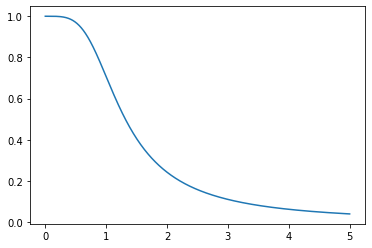

In [12]:
x = np.linspace(1, 5000, 1000)
y = lambdify(w, abs(H), 'numpy')

# rescale x axis
plt.plot(x/1000, y(x));

Which must be one of the right answers.